# **Import Packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import numpy as np

In [2]:
! pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 12.6 MB/s eta 0:00:00


In [3]:
import re
import os
import nltk
import nlpaug.augmenter.word as naw
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# download necessary NLTK data (only need to run this once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# For XGBoost
from xgboost import XGBClassifier
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

In [7]:
! pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 67.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 KB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
# For flair
from flair.nn import Classifier
from flair.data import Sentence

# **Import Data**

In [46]:
reviews_csv = pd.read_csv('reviews.csv')
reviews_csv.head()

,Sentiment,Time,Text
0,positive,18/6/21,This is a very healthy dog food. Good for thei...
1,positive,7/7/21,I've been very pleased with the Natural Balanc...
2,positive,18/6/21,"Before I was educated about feline nutrition, ..."
3,positive,7/7/21,"My holistic vet recommended this, along with a..."
4,positive,1/7/21,I bought this coffee because its much cheaper ...


In [47]:
reviews_csv['Sentiment'].value_counts()

positive    4030
negative    1414
Name: Sentiment, dtype: int64

<Axes: >

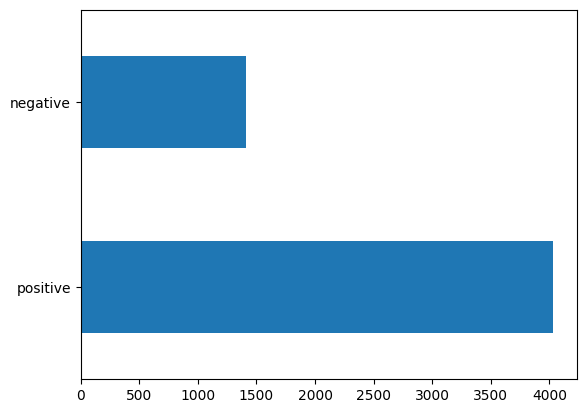

In [34]:
reviews_csv['Sentiment'].value_counts().plot(kind='barh')

Data is **imbalanced**. 

The no. of positive examples are way more than the number of negative training examples. Thus, our model will be biased towards predicting the 'positive' label class. To avoid this, we will have to balance the classes by **generating more negative training examples**.

In [48]:
# split data by Sentiment
positive_reviews = reviews_csv[reviews_csv.Sentiment == 'positive']
negative_reviews = reviews_csv[reviews_csv.Sentiment == 'negative']

# split data by 3:7
positive_train, positive_test = train_test_split(positive_reviews, test_size=0.3, random_state=101)
negative_train, negative_test = train_test_split(negative_reviews, test_size=0.3, random_state=101)

print("No. of positive training examples: ", positive_train.shape)
print("No. of positive testing examples: ", positive_test.shape)
print("No. of negative training data: ", negative_train.shape)
print("No. of positive testing examples: ", negative_test.shape)

No. of positive training examples:  (2821, 3)
No. of positive testing examples:  (1209, 3)
No. of negative training data:  (989, 3)
No. of positive testing examples:  (425, 3)


In [49]:
train_data = pd.concat([positive_train, negative_train])
test_data = pd.concat([positive_test, negative_test])

# Drop 'Time' column as we don't use it in training or testing
train_data.drop(['Time'], axis = 1, inplace = True)
test_data.drop(['Time'], axis = 1, inplace = True)

print("No. of training examples: ", train_data.shape)
print("No. of testing examples: ", test_data.shape)

No. of training examples:  (3810, 2)
No. of testing examples:  (1634, 2)


# **Pre-Processing**

In [50]:
# Define helper-functions

# Function to remove the html symbols in Text
def remove_html(text):
    regex = r"<[^>]+>"
    text_new = re.sub(regex, " ", text)
    return text_new

# Pre-process
def sa_preprocess(text):
    # convert to lowercase
    text = text.lower()
    # remove non-alphabetic characters
    text = re.sub(r'[^a-z]', ' ', text)
    # tokenize the text into words
    tokens = word_tokenize(text)
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [51]:
# Function to augment negative training data
def augment_train(train_data):
  positive_texts = train_data[train_data['Sentiment'] == 'positive']['Text'].tolist()
  negative_texts = train_data[train_data['Sentiment'] == 'negative']['Text'].tolist()

  # Remove html from all train examples
  train_data['Text'] = train_data['Text'].apply(remove_html)

  # Over-sample negative training examples using nlp-aug
  aug = naw.SynonymAug()
  augmented_texts = aug.augment(negative_texts, n=len(negative_texts))
  negative_labels = ['negative'] * len(negative_texts)
  augmented_df = pd.DataFrame({'Text': augmented_texts, 'Sentiment': negative_labels})

  # Combine Over-sampled examples with train_data
  train_data = pd.concat([train_data, augmented_df], ignore_index=True)

  return train_data


In [52]:
train_data_XGB = augment_train(train_data)
print("Shape after augmenting negative training samples: ", train_data_XGB.shape)

train_data_flair = train_data_XGB.copy()

# apply the preprocessing function to the text data
train_data_XGB['Text'] = train_data_XGB['Text'].apply(sa_preprocess)

Shape after augmenting negative training samples:  (4799, 2)


In [58]:
test_data_flair = pd.DataFrame()
test_data_flair['Flair_processed_text'] = test_data['Text'].apply(remove_html)

label_map = {
    'positive': 1,
    'negative': 0,
}

test_data_flair['sentiment_label'] = test_data['Sentiment'].map(label_map)

In [18]:
# test_data.to_csv('test_data.csv')

In [62]:
train_data_flair

,Sentiment,Text
0,positive,Great tasting coffiee!! One of the best I've e...
1,positive,These were really good. I got them free to try...
2,positive,I thought that this was a very tasty treat. V...
3,positive,This Honey Granules is tasty and a welcome alt...
4,positive,The recommendation when we bought our puppies ...
...,...,...
4794,negative,"To me, fruit juice in small cans comprise simp..."
4795,negative,I drank a single can of the Switch Orange Tang...
4796,negative,this paste is actually what first got me into ...
4797,negative,We give birth been ordering these chicken jerk...


# **Model 1: Flair**

In [63]:
# Load Model
tagger = Classifier.load('sentiment')

flair_prob = []
flair_sentiments = []

for review in train_data_flair['Text'].to_list():
    
    # Convert format to Sentence
    sentence = Sentence(review)
    
    # Make prediction using flair
    tagger.predict(sentence)
    
    # extract sentiment prediction
    flair_prob.append(sentence.labels[0].score)  # numerical score 0-1
    flair_sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'

2023-04-01 07:59:40,411 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpfvwx06jm


100%|██████████| 253M/253M [00:16<00:00, 16.4MB/s]

2023-04-01 07:59:57,118 copying /tmp/tmpfvwx06jm to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2023-04-01 07:59:58,001 removing temp file /tmp/tmpfvwx06jm


In [64]:
flair_pos_probs = [0] *  len(flair_prob)

# Store positive probablity predicted by Flair
for i in range(0,len(flair_prob)):
    if flair_sentiments[i] == "NEGATIVE":
        flair_pos_probs[i] = 1 - flair_prob[i]
    
    elif flair_sentiments[i] == "POSITIVE":
        flair_pos_probs[i] = flair_prob[i]


In [70]:
len(flair_pos_probs )

4799

In [73]:
label_map_2 = {
    'POSITIVE': 1,
    'NEGATIVE': 0,
}

train_data_flair['flair_sentiment'] = flair_sentiments
train_data_flair['flair_sentiment'] = train_data_flair['flair_sentiment'].map(label_map_2)
train_data_flair['flair_prob'] = flair_pos_probs
train_data_flair

,Sentiment,Text,flair_sentiment,flair_prob
0,positive,Great tasting coffiee!! One of the best I've e...,1,0.999896
1,positive,These were really good. I got them free to try...,1,0.991827
2,positive,I thought that this was a very tasty treat. V...,1,0.998403
3,positive,This Honey Granules is tasty and a welcome alt...,1,0.999973
4,positive,The recommendation when we bought our puppies ...,0,0.000130
...,...,...,...,...
4794,negative,"To me, fruit juice in small cans comprise simp...",0,0.000142
4795,negative,I drank a single can of the Switch Orange Tang...,0,0.000005
4796,negative,this paste is actually what first got me into ...,0,0.000044
4797,negative,We give birth been ordering these chicken jerk...,1,0.829753


In [ ]:
# obtain predictions on test data
flair_prob = []
flair_sentiments = []

for review in test_data_flair['Flair_processed_text'].to_list():
    
    # Convert format to Sentence
    sentence = Sentence(review)
    
    # Make prediction using flair
    tagger.predict(sentence)
    
    # extract sentiment prediction
    flair_prob.append(sentence.labels[0].score)  # numerical score 0-1
    flair_sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'


In [79]:
len(flair_sentiments)

1634

In [81]:
flair_pos_probs = [0] *  len(flair_prob)

# Store positive probablity predicted by Flair
for i in range(0,len(flair_prob)):
    if flair_sentiments[i] == "NEGATIVE":
        flair_pos_probs[i] = 1 - flair_prob[i]
    
    elif flair_sentiments[i] == "POSITIVE":
        flair_pos_probs[i] = flair_prob[i]

test_data_flair['flair_sentiment'] = np.array(flair_sentiments)
test_data_flair['flair_sentiment'] = test_data_flair['flair_sentiment'].map(label_map_2)
test_data_flair['flair_prob'] = flair_pos_probs
test_data_flair

,Flair_processed_text,sentiment_label,flair_sentiment,flair_prob
3672,I eat a mix of this along with the [ASIN:B000E...,1,1,9.999155e-01
1149,"I tried Congo Bongo in my friend's house, and ...",1,1,9.993942e-01
2135,I eat oatmeal almost every morning in the fall...,1,1,9.997726e-01
3287,"Interesting concept! Very tasty too, I used th...",1,1,9.993429e-01
3607,"If you are looking for a tasty snack, look no ...",1,1,9.995375e-01
...,...,...,...,...
4784,Going gluten free is not optional for those di...,0,0,6.318092e-06
4286,This is the most expensive water I've seen. Wh...,0,0,1.125336e-04
5316,This tea is an excellent herbal tea. Love the ...,0,1,9.935340e-01
4626,I received a single 8.5 once container of ONE ...,0,0,5.960464e-07


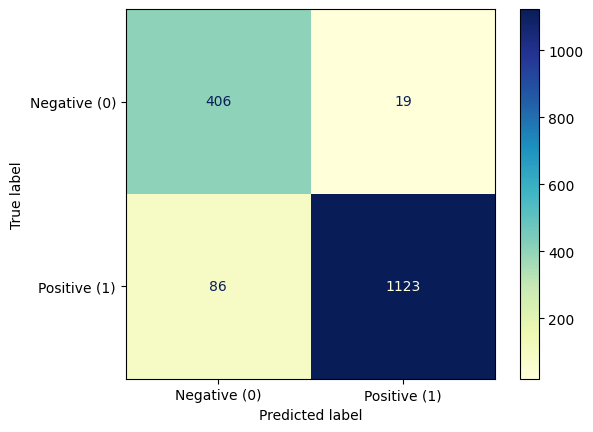

In [84]:
# On flair test data
labels = ['Negative (0)', 'Positive (1)']
cm = confusion_matrix(test_data_flair['sentiment_label'], test_data_flair['flair_sentiment'])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = 'YlGnBu');

In [86]:
print("F1 score: ", f1_score(test_data_flair['sentiment_label'], test_data_flair['flair_sentiment']))
print("PR_AUC score: ", average_precision_score(test_data_flair['sentiment_label'], test_data_flair['flair_prob']))
print("ROC_AUC score: ", roc_auc_score(test_data_flair['sentiment_label'], test_data_flair['flair_prob']))
print("Accuracy: ", accuracy_score(test_data_flair['sentiment_label'], test_data_flair['flair_sentiment']))

F1 score:  0.955338153977031
PR_AUC score:  0.993128362853135
ROC_AUC score:  0.9834544835303848
Accuracy:  0.9357405140758874


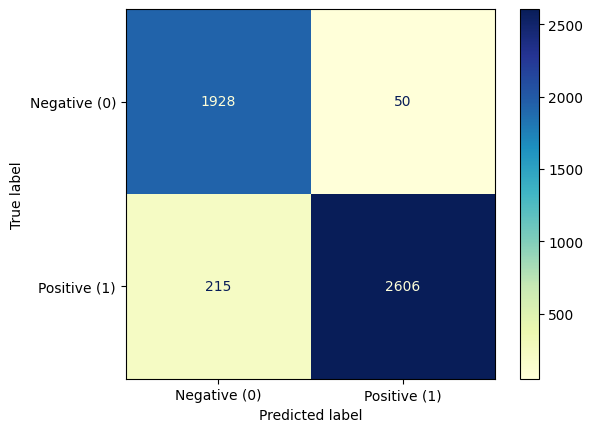

In [89]:
# On flair train data
label_map = {
    'positive': 1,
    'negative': 0,
}
cm = confusion_matrix(train_data_flair['Sentiment'].map(label_map), train_data_flair['flair_sentiment'])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = 'YlGnBu');

In [90]:
print("F1 score: ", f1_score(train_data_flair['Sentiment'].map(label_map), train_data_flair['flair_sentiment']))
print("PR_AUC score: ", average_precision_score(train_data_flair['Sentiment'].map(label_map), train_data_flair['flair_prob']))
print("ROC_AUC score: ", roc_auc_score(train_data_flair['Sentiment'].map(label_map), train_data_flair['flair_prob']))
print("Accuracy: ", accuracy_score(train_data_flair['Sentiment'].map(label_map), train_data_flair['flair_sentiment']))

F1 score:  0.9516158480920212
PR_AUC score:  0.9903965413746663
ROC_AUC score:  0.9871944813723738
Accuracy:  0.9447801625338612


In [91]:
# Save flair test and train data predictions
test_data_flair.to_csv('Flair_data/test_data_flair.csv')
train_data_flair.to_csv('Flair_data/train_data_flair.csv')

# **Further Pre-Process for XGBoost**

In [92]:
train_data_XGB.head()

,Sentiment,Text
0,positive,"[great, tasting, coffiee, one, best, ever, pro..."
1,positive,"[really, good, got, free, try, loved, filling,..."
2,positive,"[thought, tasty, treat, comparable, non, glute..."
3,positive,"[honey, granule, tasty, welcome, alternative, ..."
4,positive,"[recommendation, bought, puppy, lhasa, bichon,..."


In [93]:
train_data_XGB['Sentiment'].value_counts()

positive    2821
negative    1978
Name: Sentiment, dtype: int64

<Axes: >

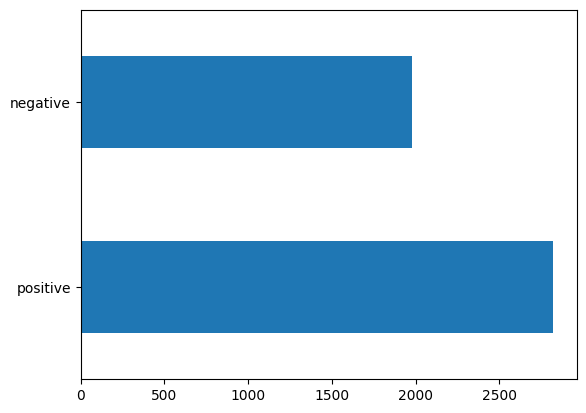

In [94]:
train_data_XGB['Sentiment'].value_counts().plot(kind='barh')

In [125]:
train_data_XGB

,Sentiment,Text
0,positive,"[great, tasting, coffiee, one, best, ever, pro..."
1,positive,"[really, good, got, free, try, loved, filling,..."
2,positive,"[thought, tasty, treat, comparable, non, glute..."
3,positive,"[honey, granule, tasty, welcome, alternative, ..."
4,positive,"[recommendation, bought, puppy, lhasa, bichon,..."
...,...,...
4794,negative,"[fruit, juice, small, can, comprise, simply, s..."
4795,negative,"[drank, single, switch, orange, tangerine, fla..."
4796,negative,"[paste, actually, first, got, thai, curry, tim..."
4797,negative,"[give, birth, ordering, chicken, jerky, treat,..."


In [126]:
def features_sa_train(train_data):

    ## Features

    # train a Word2Vec model on the preprocessed text data
    word2vec_model = Word2Vec(train_data['Text'], min_count=1)
    train_embeddings = train_data['Text'].apply(lambda x: np.mean([word2vec_model.wv[Text] for Text in x if Text in word2vec_model.wv.key_to_index], axis = 0))

    # create a new DataFrame for the feature matrix
    features_df = pd.DataFrame(train_embeddings.tolist(), index = train_embeddings.index)

    pca_emb = PCA(n_components=0.98)
    pca_emb.fit(features_df)
    features_emb_pca = pca_emb.transform(features_df)

    # create a new DataFrame for the PCA features
    pca_emb_cols = [f"PC_emb{i+1}" for i in range(features_emb_pca.shape[1])]
    pca_df_emb = pd.DataFrame(features_emb_pca, columns=pca_emb_cols)

    # create a TF-IDF vectorizer object
    tfidf = TfidfVectorizer()

    # fit the vectorizer on the preprocessed text data
    tfidf.fit(train_data['Text'].apply(lambda x: ' '.join(x)))

    # obtain the TF-IDF feature matrix for the training and test data
    train_matrix = tfidf.transform(train_data['Text'].apply(lambda x: ' '.join(x))).toarray()
    tfidf_features_df = pd.DataFrame(train_matrix, columns = tfidf.get_feature_names_out())
    
    pca_tfidf = PCA(n_components=0.95)
    pca_tfidf.fit(tfidf_features_df)
    features_tfidf_pca = pca_tfidf.transform(tfidf_features_df)

    # create a new DataFrame for the PCA features
    pca_tfidf_cols = [f"PC_tfidf{i+1}" for i in range(features_tfidf_pca.shape[1])]
    pca_df_tfidf = pd.DataFrame(features_tfidf_pca, columns=pca_tfidf_cols)
    
    # add the TF-IDF features to the feature matrix DataFrame
    features_df = pd.concat([pca_df_tfidf, pca_df_emb], axis=1)

    # add the label column to the feature matrix DataFrame
    features_df ['Sentiment'] = train_data_XGB['Sentiment']

    return features_df, word2vec_model, tfidf, pca_emb, pca_tfidf


In [127]:
features_train_XGB, word2vec_model, tfidf, pca, scaler = features_sa_train(train_data_XGB)
features_train_XGB

,PC_tfidf1,PC_tfidf2,PC_tfidf3,PC_tfidf4,PC_tfidf5,PC_tfidf6,PC_tfidf7,PC_tfidf8,PC_tfidf9,PC_tfidf10,...,PC_tfidf2588,PC_tfidf2589,PC_tfidf2590,PC_tfidf2591,PC_tfidf2592,PC_emb1,PC_emb2,PC_emb3,PC_emb4,Sentiment
0,-0.026870,0.014780,-0.066090,-0.049442,-0.085450,-0.015347,-0.015618,0.066778,0.013408,0.029274,...,-0.011772,0.011120,-0.013049,-0.013416,0.013363,-0.908108,0.286573,0.047269,0.020724,positive
1,-0.037532,-0.009627,-0.055171,0.028658,0.036241,0.045767,-0.004236,0.029006,-0.038153,0.090347,...,-0.001758,0.000884,-0.004788,0.008776,-0.006394,-0.483436,0.126939,0.085002,-0.072216,positive
2,-0.089494,-0.020471,-0.014341,-0.004884,0.090424,0.060984,-0.064397,0.136049,0.033115,0.229738,...,-0.001559,0.001747,-0.001179,0.001426,0.012269,-0.311690,0.202991,0.407431,-0.075170,positive
3,0.047959,-0.077866,-0.007508,0.000674,-0.008423,-0.009463,0.011825,0.038286,-0.054915,0.043033,...,-0.006754,0.009863,0.002995,-0.002928,-0.000309,0.435801,0.028121,0.079447,0.069263,positive
4,-0.071033,-0.029630,0.016051,-0.077558,0.079707,-0.051153,-0.019837,0.011496,-0.067342,-0.079547,...,0.003875,0.010234,0.002296,0.010692,0.018027,0.251700,0.176635,0.043838,-0.027251,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,-0.053339,-0.015767,0.358656,0.050302,-0.220804,-0.073616,-0.078025,-0.004885,0.008596,-0.064193,...,-0.001527,0.003988,-0.004332,-0.005067,0.000644,0.461873,-0.045002,0.086957,0.022277,negative
4795,-0.019146,-0.020761,0.294628,0.142159,-0.143682,-0.141083,0.001164,-0.068657,-0.094025,-0.041758,...,0.001919,-0.000446,-0.003370,0.001575,-0.001439,-0.198675,-0.117328,0.145589,0.068221,negative
4796,-0.035514,-0.003851,-0.000797,-0.056687,0.003122,0.004508,0.067815,-0.008519,-0.063399,-0.040929,...,-0.001019,0.000050,0.001323,0.007061,0.002634,0.224503,0.288147,-0.068030,0.001015,negative
4797,-0.107003,-0.027570,0.035025,-0.155991,0.215039,-0.081679,-0.102661,0.004906,0.012459,-0.088581,...,0.004874,-0.012197,-0.001698,0.010986,-0.003814,0.038847,0.361251,0.023209,-0.046703,negative


In [130]:
def features_sa_test(test_data, word2vec_model, tfidf, pca_emb, pca_tfidf):

    # train a Word2Vec model on the preprocessed text data
    test_embeddings = test_data['Text'].apply(lambda x: np.mean([word2vec_model.wv[Text] for Text in x if Text in word2vec_model.wv.key_to_index], axis = 0))

    # create a new DataFrame for the feature matrix
    features_df = pd.DataFrame(test_embeddings.tolist(), index = test_embeddings.index)

    # perform PCA with n_components set to retain 98% of variance
    features_emb_pca = pca_emb.transform(features_df)

    # create a new DataFrame for the PCA features
    pca_emb_cols = [f"PC_emb{i+1}" for i in range(features_emb_pca.shape[1])]
    pca_df_emb = pd.DataFrame(features_emb_pca, columns=pca_emb_cols)

    # obtain the TF-IDF feature matrix for the training and test data
    test_matrix = tfidf.transform(test_data['Text'].apply(lambda x: ' '.join(x))).toarray()
    tfidf_features_df = pd.DataFrame(test_matrix, columns = tfidf.get_feature_names_out())
    
    # perform PCA with n_components set to retain 95% of variance
    features_tfidf_pca = pca_tfidf.transform(tfidf_features_df)

    # create a new DataFrame for the PCA features
    pca_tfidf_cols = [f"PC_tfidf{i+1}" for i in range(features_tfidf_pca.shape[1])]
    pca_df_tfidf = pd.DataFrame(features_tfidf_pca, columns=pca_tfidf_cols)

    # add the TF-IDF features to the feature matrix DataFrame
    pca_df_tfidf.reset_index(drop=True, inplace=True)
    pca_df_emb.reset_index(drop=True, inplace=True)  
    features_df = pd.concat([pca_df_tfidf, pca_df_emb], axis=1)

    
    return features_df


In [131]:
test_data_XGB = pd.DataFrame()
test_data_XGB['Text'] = test_data['Text'].apply(remove_html)
# test_data_XGB['Sentiment'] = test_data['Sentiment']

# apply the preprocessing function to the text data
test_data_XGB['Text'] = test_data_XGB['Text'].apply(sa_preprocess)

# Obtain features
features_test_XGB = features_sa_test(test_data_XGB, word2vec_model, tfidf, pca, scaler)
features_test_XGB


,PC_tfidf1,PC_tfidf2,PC_tfidf3,PC_tfidf4,PC_tfidf5,PC_tfidf6,PC_tfidf7,PC_tfidf8,PC_tfidf9,PC_tfidf10,...,PC_tfidf2587,PC_tfidf2588,PC_tfidf2589,PC_tfidf2590,PC_tfidf2591,PC_tfidf2592,PC_emb1,PC_emb2,PC_emb3,PC_emb4
0,-0.045587,-0.011774,-0.046886,-0.007489,0.000574,0.019068,-0.034971,0.015435,-0.060345,-0.010568,...,0.001565,0.003844,0.004361,0.003734,0.014003,0.003996,0.222722,0.098548,0.061380,-0.016107
1,0.320700,-0.258495,-0.083542,-0.021845,-0.021721,-0.011469,-0.109244,0.025855,0.056924,-0.161507,...,-0.007560,0.001727,-0.000767,0.009973,-0.001207,-0.003481,-1.248988,-0.157310,-0.140618,-0.061779
2,-0.033222,0.001457,-0.010891,-0.036292,0.047130,0.026461,0.002503,0.054047,-0.044769,-0.059492,...,-0.002193,-0.003819,0.014402,0.000131,0.013601,-0.011753,0.057972,0.185369,-0.017900,0.051755
3,-0.033627,0.003919,-0.014912,0.048170,0.008201,0.009946,0.026059,0.031726,0.035126,0.029905,...,0.000343,0.014164,0.004241,0.006873,0.005566,0.001929,-0.218062,-0.093616,0.102238,0.038539
4,-0.073947,-0.011479,-0.107671,0.178282,-0.002978,0.060726,-0.228178,0.238894,-0.187807,0.130871,...,-0.008417,-0.001991,0.004175,-0.004283,0.002876,0.001918,-0.480619,-0.046638,0.198277,0.054572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,-0.046231,-0.013135,0.004767,-0.026027,0.030920,-0.001078,0.020721,0.019653,0.047206,0.086679,...,-0.007884,0.006428,-0.001375,0.006090,-0.001437,-0.005952,0.986149,0.025961,0.054795,-0.033264
1630,-0.023645,0.000422,0.008412,-0.014270,-0.005376,-0.035179,0.085538,-0.004203,-0.000091,0.011367,...,-0.004369,0.001441,-0.005100,-0.007281,-0.011453,-0.000568,0.893919,-0.147299,-0.036768,0.038152
1631,0.124974,-0.154029,0.007589,-0.121362,-0.010436,0.030953,0.037080,0.033771,-0.019304,0.026622,...,-0.010628,0.015247,-0.003063,0.013460,-0.002224,-0.003442,0.110031,0.230548,-0.033646,0.020740
1632,0.043545,-0.003837,0.010329,0.169607,-0.026717,-0.106723,0.085615,-0.111115,-0.074941,-0.083713,...,-0.007650,-0.013207,0.004744,0.007753,-0.005829,0.014628,-0.189556,-0.333771,-0.008154,-0.020434


In [132]:
# Map Sentiment to Factor
label_map = {
    'positive': 1,
    'negative': 0,
}

features_train_XGB['Sentiment'] = features_train_XGB['Sentiment'].map(label_map)
features_train_XGB.head()

,PC_tfidf1,PC_tfidf2,PC_tfidf3,PC_tfidf4,PC_tfidf5,PC_tfidf6,PC_tfidf7,PC_tfidf8,PC_tfidf9,PC_tfidf10,...,PC_tfidf2588,PC_tfidf2589,PC_tfidf2590,PC_tfidf2591,PC_tfidf2592,PC_emb1,PC_emb2,PC_emb3,PC_emb4,Sentiment
0,-0.026870,0.014780,-0.066090,-0.049442,-0.085450,-0.015347,-0.015618,0.066778,0.013408,0.029274,...,-0.011772,0.011120,-0.013049,-0.013416,0.013363,-0.908108,0.286573,0.047269,0.020724,1
1,-0.037532,-0.009627,-0.055171,0.028658,0.036241,0.045767,-0.004236,0.029006,-0.038153,0.090347,...,-0.001758,0.000884,-0.004788,0.008776,-0.006394,-0.483436,0.126939,0.085002,-0.072216,1
2,-0.089494,-0.020471,-0.014341,-0.004884,0.090424,0.060984,-0.064397,0.136049,0.033115,0.229738,...,-0.001559,0.001747,-0.001179,0.001426,0.012269,-0.311690,0.202991,0.407431,-0.075170,1
3,0.047959,-0.077866,-0.007508,0.000674,-0.008423,-0.009463,0.011825,0.038286,-0.054915,0.043033,...,-0.006754,0.009863,0.002995,-0.002928,-0.000309,0.435801,0.028121,0.079447,0.069263,1
4,-0.071033,-0.029630,0.016051,-0.077558,0.079707,-0.051153,-0.019837,0.011496,-0.067342,-0.079547,...,0.003875,0.010234,0.002296,0.010692,0.018027,0.251700,0.176635,0.043838,-0.027251,1


In [134]:
label_map = {
    'positive': 1,
    'negative': 0,
}
features_test_XGB['Sentiment'] =  test_data['Sentiment'].map(label_map)
features_test_XGB.head()

,PC_tfidf1,PC_tfidf2,PC_tfidf3,PC_tfidf4,PC_tfidf5,PC_tfidf6,PC_tfidf7,PC_tfidf8,PC_tfidf9,PC_tfidf10,...,PC_tfidf2588,PC_tfidf2589,PC_tfidf2590,PC_tfidf2591,PC_tfidf2592,PC_emb1,PC_emb2,PC_emb3,PC_emb4,Sentiment
0,-0.045587,-0.011774,-0.046886,-0.007489,0.000574,0.019068,-0.034971,0.015435,-0.060345,-0.010568,...,0.003844,0.004361,0.003734,0.014003,0.003996,0.222722,0.098548,0.061380,-0.016107,1.0
1,0.320700,-0.258495,-0.083542,-0.021845,-0.021721,-0.011469,-0.109244,0.025855,0.056924,-0.161507,...,0.001727,-0.000767,0.009973,-0.001207,-0.003481,-1.248988,-0.157310,-0.140618,-0.061779,NaN
2,-0.033222,0.001457,-0.010891,-0.036292,0.047130,0.026461,0.002503,0.054047,-0.044769,-0.059492,...,-0.003819,0.014402,0.000131,0.013601,-0.011753,0.057972,0.185369,-0.017900,0.051755,NaN
3,-0.033627,0.003919,-0.014912,0.048170,0.008201,0.009946,0.026059,0.031726,0.035126,0.029905,...,0.014164,0.004241,0.006873,0.005566,0.001929,-0.218062,-0.093616,0.102238,0.038539,NaN
4,-0.073947,-0.011479,-0.107671,0.178282,-0.002978,0.060726,-0.228178,0.238894,-0.187807,0.130871,...,-0.001991,0.004175,-0.004283,0.002876,0.001918,-0.480619,-0.046638,0.198277,0.054572,1.0


In [135]:
test_data['Sentiment'].map(label_map).value_counts()

1    1209
0     425
Name: Sentiment, dtype: int64

In [136]:
test_data['Sentiment']

3672    positive
1149    positive
2135    positive
3287    positive
3607    positive
          ...   
4784    negative
4286    negative
5316    negative
4626    negative
4449    negative
Name: Sentiment, Length: 1634, dtype: object

In [137]:
# Save XGB test and train data with features
features_test_XGB.to_csv('XGB_data/features_test_XGB.csv')
features_train_XGB.to_csv('XGB_data/features_train_XGB.csv')

In [4]:
train_data_flair = pd.read_csv('/Users/nnerella/Downloads/flair_data/train_data_flair.csv')
test_data_flair = pd.read_csv('/Users/nnerella/Downloads/flair_data/test_data_flair.csv')
features_test_XGB= pd.read_csv('/Users/nnerella/Downloads/XGB_data/features_test_XGB.csv')
features_train_XGB = pd.read_csv('/Users/nnerella/Downloads/XGB_data/features_train_XGB.csv')

In [11]:
train_data_flair = train_data_flair.iloc[: , 1:]
test_data_flair = test_data_flair.iloc[: , 1:]

In [13]:
features_test_XGB = features_test_XGB.iloc[: , 1:]
features_train_XGB = features_train_XGB.iloc[: , 1:]
features_test_XGB['Sentiment'] = test_data_flair['sentiment_label']
features_test_XGB

,PC_tfidf2,PC_tfidf3,PC_tfidf4,PC_tfidf5,PC_tfidf6,PC_tfidf7,PC_tfidf8,PC_tfidf9,PC_tfidf10,PC_tfidf11,...,PC_tfidf2588,PC_tfidf2589,PC_tfidf2590,PC_tfidf2591,PC_tfidf2592,PC_emb1,PC_emb2,PC_emb3,PC_emb4,Sentiment
0,-0.011774,-0.046886,-0.007489,0.000574,0.019068,-0.034971,0.015435,-0.060345,-0.010568,0.033709,...,0.003844,0.004361,0.003734,0.014003,0.003996,0.222722,0.098548,0.061380,-0.016107,1
1,-0.258495,-0.083542,-0.021845,-0.021721,-0.011469,-0.109244,0.025855,0.056924,-0.161507,-0.060726,...,0.001727,-0.000767,0.009973,-0.001207,-0.003481,-1.248988,-0.157310,-0.140618,-0.061779,1
2,0.001457,-0.010891,-0.036292,0.047130,0.026461,0.002503,0.054047,-0.044769,-0.059492,-0.047713,...,-0.003819,0.014402,0.000131,0.013601,-0.011753,0.057972,0.185369,-0.017900,0.051755,1
3,0.003919,-0.014912,0.048170,0.008201,0.009946,0.026059,0.031726,0.035126,0.029905,-0.035025,...,0.014164,0.004241,0.006873,0.005566,0.001929,-0.218062,-0.093616,0.102238,0.038539,1
4,-0.011479,-0.107671,0.178282,-0.002978,0.060726,-0.228178,0.238894,-0.187807,0.130871,0.114425,...,-0.001991,0.004175,-0.004283,0.002876,0.001918,-0.480619,-0.046638,0.198277,0.054572,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,-0.013135,0.004767,-0.026027,0.030920,-0.001078,0.020721,0.019653,0.047206,0.086679,-0.003621,...,0.006428,-0.001375,0.006090,-0.001437,-0.005952,0.986149,0.025961,0.054795,-0.033264,0
1630,0.000422,0.008412,-0.014270,-0.005376,-0.035179,0.085538,-0.004203,-0.000091,0.011367,-0.042879,...,0.001441,-0.005100,-0.007281,-0.011453,-0.000568,0.893919,-0.147299,-0.036768,0.038152,0
1631,-0.154029,0.007589,-0.121362,-0.010436,0.030953,0.037080,0.033771,-0.019304,0.026622,0.003924,...,0.015247,-0.003063,0.013460,-0.002224,-0.003442,0.110031,0.230548,-0.033646,0.020740,0
1632,-0.003837,0.010329,0.169607,-0.026717,-0.106723,0.085615,-0.111115,-0.074941,-0.083713,-0.003948,...,-0.013207,0.004744,0.007753,-0.005829,0.014628,-0.189556,-0.333771,-0.008154,-0.020434,0


In [14]:
features_train_XGB

,PC_tfidf2,PC_tfidf3,PC_tfidf4,PC_tfidf5,PC_tfidf6,PC_tfidf7,PC_tfidf8,PC_tfidf9,PC_tfidf10,PC_tfidf11,...,PC_tfidf2588,PC_tfidf2589,PC_tfidf2590,PC_tfidf2591,PC_tfidf2592,PC_emb1,PC_emb2,PC_emb3,PC_emb4,Sentiment
0,0.014780,-0.066090,-0.049442,-0.085450,-0.015347,-0.015618,0.066778,0.013408,0.029274,-0.034070,...,-0.011772,0.011120,-0.013049,-0.013416,0.013363,-0.908108,0.286573,0.047269,0.020724,1
1,-0.009627,-0.055171,0.028658,0.036241,0.045767,-0.004236,0.029006,-0.038153,0.090347,0.035615,...,-0.001758,0.000884,-0.004788,0.008776,-0.006394,-0.483436,0.126939,0.085002,-0.072216,1
2,-0.020471,-0.014341,-0.004884,0.090424,0.060984,-0.064397,0.136049,0.033115,0.229738,-0.034435,...,-0.001559,0.001747,-0.001179,0.001426,0.012269,-0.311690,0.202991,0.407431,-0.075170,1
3,-0.077866,-0.007508,0.000674,-0.008423,-0.009463,0.011825,0.038286,-0.054915,0.043033,-0.016185,...,-0.006754,0.009863,0.002995,-0.002928,-0.000309,0.435801,0.028121,0.079447,0.069263,1
4,-0.029630,0.016051,-0.077558,0.079707,-0.051153,-0.019837,0.011496,-0.067342,-0.079547,0.100877,...,0.003875,0.010234,0.002296,0.010692,0.018027,0.251700,0.176635,0.043838,-0.027251,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,-0.015767,0.358656,0.050302,-0.220804,-0.073616,-0.078025,-0.004885,0.008596,-0.064193,0.023454,...,-0.001527,0.003988,-0.004332,-0.005067,0.000644,0.461873,-0.045002,0.086957,0.022277,0
4795,-0.020761,0.294628,0.142159,-0.143682,-0.141083,0.001164,-0.068657,-0.094025,-0.041758,-0.044533,...,0.001919,-0.000446,-0.003370,0.001575,-0.001439,-0.198675,-0.117328,0.145589,0.068221,0
4796,-0.003851,-0.000797,-0.056687,0.003122,0.004508,0.067815,-0.008519,-0.063399,-0.040929,0.024625,...,-0.001019,0.000050,0.001323,0.007061,0.002634,0.224503,0.288147,-0.068030,0.001015,0
4797,-0.027570,0.035025,-0.155991,0.215039,-0.081679,-0.102661,0.004906,0.012459,-0.088581,-0.003407,...,0.004874,-0.012197,-0.001698,0.010986,-0.003814,0.038847,0.361251,0.023209,-0.046703,0


## XGBoost

In [22]:
# create a default XGBoost classifier

model = XGBClassifier(
    random_state=42, 
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 3
kfold = StratifiedKFold(n_splits=num_folds)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model = grid.fit(features_train_XGB.iloc[: , :-1], features_train_XGB['Sentiment'])

CPU times: user 5min 33s, sys: 7.62 s, total: 5min 41s
Wall time: 59min 51s


In [23]:
print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

Best score: 0.9576454769056103
Best model: {'subsample': 0.6, 'reg_lambda': 1, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [24]:
xgb_probs = best_model.predict_proba(features_test_XGB.iloc[: , :-1])
xgb_sentiment = best_model.predict(features_test_XGB.iloc[: , :-1])

In [25]:
xgb_probs_df = pd.DataFrame(data = xgb_probs, columns = ['NEGATIVE', 'POSITIVE'])
xgb_probs_df

,NEGATIVE,POSITIVE
0,0.005754,0.994246
1,0.013182,0.986818
2,0.075385,0.924615
3,0.013225,0.986775
4,0.017191,0.982809
...,...,...
1629,0.473790,0.526210
1630,0.437878,0.562122
1631,0.826050,0.173950
1632,0.617891,0.382109


In [26]:
XGB_results_df = pd.DataFrame()
XGB_results_df['xgb_sentiment'] = np.array(xgb_sentiment)
XGB_results_df['xgb_prob'] = xgb_probs_df['POSITIVE']

In [28]:
print("F1 score: ", f1_score(features_test_XGB['Sentiment'], XGB_results_df['xgb_sentiment']))
print("PR_AUC score: ", average_precision_score(features_test_XGB['Sentiment'],XGB_results_df['xgb_prob']))
print("ROC_AUC score: ", roc_auc_score(features_test_XGB['Sentiment'], XGB_results_df['xgb_prob']))
print("Accuracy: ", accuracy_score(features_test_XGB['Sentiment'], XGB_results_df['xgb_sentiment']))

F1 score:  0.8932342588971451
PR_AUC score:  0.9374201716085224
ROC_AUC score:  0.8613749817544882
Accuracy:  0.8329253365973073


In [124]:
# save in JSON format
rs.save_model("xgb_model.json")
# save in text format
rs.save_model("xgb_model.txt")

AttributeError: ignored

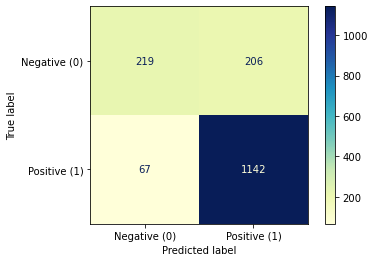

In [29]:
labels = ['Negative (0)', 'Positive (1)']
cm = confusion_matrix(features_test_XGB['Sentiment'], XGB_results_df['xgb_sentiment'])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = 'YlGnBu');

## Final Ensemble

In [30]:
XGB_results_df['flair_prob'] = np.array(test_data_flair['flair_prob'])
XGB_results_df['avg_prob'] = (XGB_results_df['flair_prob'] + XGB_results_df['xgb_prob']) / 2
XGB_results_df['final_sentiment'] = np.where(XGB_results_df['avg_prob'] > 0.5, 1, 0)
XGB_results_df

,xgb_sentiment,xgb_prob,flair_prob,avg_prob,final_sentiment
0,1,0.994246,9.999155e-01,0.997081,1
1,1,0.986818,9.993942e-01,0.993106,1
2,1,0.924615,9.997726e-01,0.962194,1
3,1,0.986775,9.993429e-01,0.993059,1
4,1,0.982809,9.995375e-01,0.991173,1
...,...,...,...,...,...
1629,1,0.526210,6.318092e-06,0.263108,0
1630,1,0.562122,1.125336e-04,0.281117,0
1631,0,0.173950,9.935340e-01,0.583742,1
1632,0,0.382109,5.960464e-07,0.191055,0


In [31]:
print("F1 score: ", f1_score(features_test_XGB['Sentiment'], XGB_results_df['final_sentiment']))
print("PR_AUC score: ", average_precision_score(features_test_XGB['Sentiment'],XGB_results_df['avg_prob']))
print("ROC_AUC score: ", roc_auc_score(features_test_XGB['Sentiment'], XGB_results_df['avg_prob']))
print("Accuracy: ", accuracy_score(features_test_XGB['Sentiment'], XGB_results_df['final_sentiment']))

F1 score:  0.9616519174041298
PR_AUC score:  0.9900450519936166
ROC_AUC score:  0.9730141585170048
Accuracy:  0.9443084455324358


In [ ]:
F1 score:  0.9593908629441624
PR_AUC score:  0.9891257142921561
ROC_AUC score:  0.9708110738091762
Accuracy:  0.9412484700122399

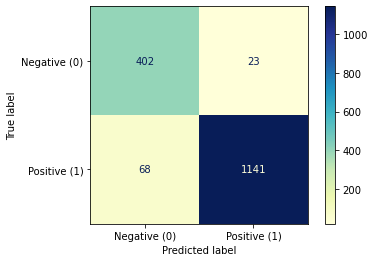

In [38]:
labels = ['Negative (0)', 'Positive (1)']
cm = confusion_matrix(features_test_XGB['Sentiment'], XGB_results_df['final_sentiment'])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = 'YlGnBu');

#### Final ensemble model performs better than the Flair model

In [33]:
XGB_results_df['true_label'] = np.array(features_test_XGB['Sentiment'])
XGB_results_df

,xgb_sentiment,xgb_prob,flair_prob,avg_prob,final_sentiment,true_label
0,1,0.994246,9.999155e-01,0.997081,1,1
1,1,0.986818,9.993942e-01,0.993106,1,1
2,1,0.924615,9.997726e-01,0.962194,1,1
3,1,0.986775,9.993429e-01,0.993059,1,1
4,1,0.982809,9.995375e-01,0.991173,1,1
...,...,...,...,...,...,...
1629,1,0.526210,6.318092e-06,0.263108,0,0
1630,1,0.562122,1.125336e-04,0.281117,0,0
1631,0,0.173950,9.935340e-01,0.583742,1,0
1632,0,0.382109,5.960464e-07,0.191055,0,0


In [34]:
XGB_results_df.to_csv('ensemble_results.csv')

In [35]:
# save in JSON format
best_model.best_estimator_.save_model("xgb_model.json")
# save in text format
#model.save_model("xgb_model.txt")
print(best_model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'auc'], gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, ...)


In [ ]:
# To load model
model_xgb_2 = XGBClassifier()
model_xgb_2.load_model("xgb_model.json")